✅ 목표
OK / NG 여부를 온도 벡터와 기준 라벨을 기반으로 자동 진단

품질 진단 결과를 요약하고, 간단한 리포트 구조까지 구성



1단계: 데이터 로딩 및 병합

In [11]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import matplotlib as mpl
import seaborn as sns
import json
from pathlib import Path

warnings.filterwarnings("ignore", category=UserWarning)

plt.rcParams['font.family'] = 'AppleGothic'  # Mac 한글폰트
mpl.rcParams['axes.unicode_minus'] = False

data_dir = Path("..") / "raw_data"
label_path = Path("..") / "labels" / "left_label.json"

# 데이터 로드
df_data = pd.read_csv(data_dir / "left_data.csv", header=None)
with open(label_path) as f:
    label_list = json.load(f)
df_label = pd.DataFrame(label_list, columns=["thickness"])
df_label["id"] = df_label.index

def final_label(row):
    ok = "OK" if 0.8 < row["thickness"] < 1.5 else "NG"
    return f"{row['grade']}_{ok}"

if "label" not in df_label.columns:
    df_label["deviation"] = df_label["thickness"].apply(
        lambda t: 0.0 if 0.8 <= t <= 1.5 else (0.8 - t if t < 0.8 else t - 1.5)
    )
    df_label["grade"] = df_label["deviation"].apply(
        lambda d: "A" if d == 0 else "B" if d <= 0.05 else "C"
    )
    df_label["label"] = df_label.apply(final_label, axis=1)

df_data["id"] = df_data.index
df = pd.merge(df_data, df_label, on="id")

df.head()


,0,1,2,3,4,5,6,7,8,9,...,81915,81916,81917,81918,81919,id,thickness,deviation,grade,label
0,17.392,17.349,17.436,17.522,17.544,17.587,17.738,17.825,17.825,17.825,...,16.237,16.106,16.259,16.215,16.193,0,1.58,0.08,C,C_NG
1,17.846,17.889,17.932,17.954,17.954,18.062,18.105,18.212,18.276,18.255,...,16.522,16.456,16.522,16.522,16.522,1,1.59,0.09,C,C_NG
2,17.284,17.306,17.327,17.392,17.371,17.414,17.457,17.652,17.630,17.674,...,16.566,16.478,16.478,16.369,16.391,2,1.60,0.10,C,C_NG
3,17.695,17.565,17.609,17.760,17.652,17.695,17.695,17.868,17.846,17.825,...,16.500,16.434,16.347,16.347,16.347,3,1.70,0.20,C,C_NG
4,17.544,17.262,17.414,17.587,17.544,17.522,17.522,17.760,17.760,17.695,...,16.369,16.391,16.193,16.325,16.347,4,1.72,0.22,C,C_NG


2단계: 간단한 품질 진단 요약 (label 기준)

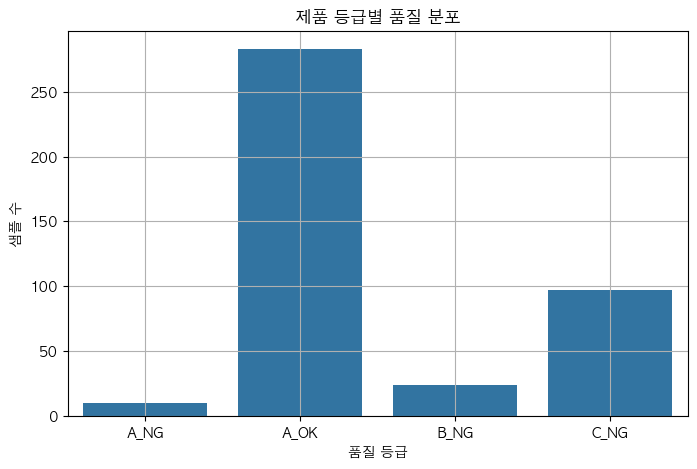

In [12]:
label_counts = df["label"].value_counts().sort_index()

plt.figure(figsize=(8,5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("제품 등급별 품질 분포")
plt.xlabel("품질 등급")
plt.ylabel("샘플 수")
plt.grid(True)
plt.show()


3단계: NG 제품 집중 분석

총 NG 샘플 수 : 131


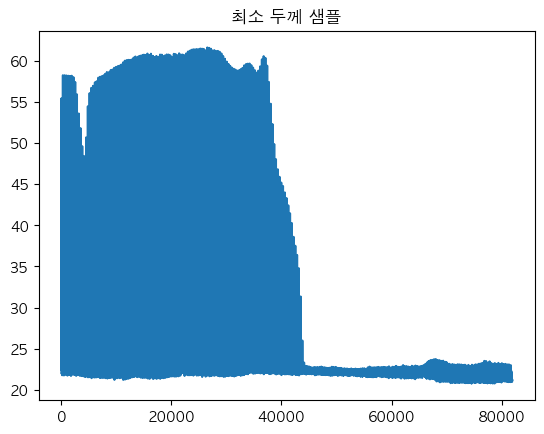

In [18]:
ng_df = df[df["label"].str.endswith("NG")]
print(f"총 NG 샘플 수 : {len(ng_df)}")

min_thickness_id = ng_df["thickness"].idxmin()
plt.plot(df_data.iloc[min_thickness_id][:-1])
plt.title(f"최소 두께 샘플")
plt.show()

4단계: 진단 결과 저장

In [19]:
save_cols = ["id", "thickness", "deviation", "grade", "label"]
df[save_cols].to_csv("quality_diagnosis_result.csv", index=False)
print("품질 진단 결과 저장 완료")

품질 진단 결과 저장 완료
